# Scenario

Analyze customer churn probability for a Telcom company

In [1]:
# We will import the data and the necessary packages

# Import the libraries
import pandas as pd
import numpy as np
import scipy as scp
import sklearn
from sklearn import metrics
# Provide classes and functions to estimate many different statistical methods
import statsmodels.api as sm

# Import libraries to help create a BLR
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Indicate situations that aren't exceptions
import warnings
warnings.filterwarnings('ignore')

# Read the data
data = pd.read_csv(r'C:\Users\patri\Desktop\LSE_CareerAccelerator\Course 3\Week 2\Data\customer_data.csv')

# Print a summary of the DataFrame to sense-check it
data.info()

C:\Users\patri\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            41188 non-null  int64  
 1   Occupation     41188 non-null  object 
 2   Status         41188 non-null  object 
 3   Edu            41188 non-null  object 
 4   House          41188 non-null  object 
 5   Loan           41188 non-null  object 
 6   Comm           41188 non-null  object 
 7   Month          41188 non-null  object 
 8   DOW            41188 non-null  object 
 9   Duration       41188 non-null  int64  
 10  Campaign       41188 non-null  int64  
 11  PosDays        41188 non-null  int64  
 12  Last_out       41188 non-null  object 
 13  Var_rate       41188 non-null  float64
 14  Price_idx      41188 non-null  float64
 15  Conf_idx       41188 non-null  float64
 16  Month_rate     41188 non-null  float64
 17  Quarterly_emp  41188 non-null  float64
 18  Target

In [2]:
# We need to remove the periods in the EDU column. We will create two lists and run a for loop to replace the values

# Create two lists: one with initial and one with new values.
intial_vals = ['illiterate', 'unknown', 'basic', 'high', 'university', 'professional']
new_vals = ['other', 'other', 'pre-school', 'high-school', 'uni', 'masters']

# Create a for loop to replace the values.
for old_val, new_val in zip(intial_vals, new_vals):
    data.loc[data['Edu'].str.contains(old_val),'Edu' ] = new_val

# Display all the unique values/check changes.
data['Edu'].unique()  

array(['pre-school', 'other', 'uni', 'high-school', 'masters'],
      dtype=object)

In [3]:
data['Edu'].value_counts()

pre-school     12513
uni            12168
high-school     9515
masters         5243
other           1749
Name: Edu, dtype: int64

### Creating Dummy variables

When fitting the decision tree we might not need to create dummy variables. An example would be when the variables are already discrete. 
Since we already did this step for the BLR and will do it for the SVR as well we will keep it consistent and run the transformation through the dummy variables. 

In [4]:
# Name the new DataFrame as cat_vars and specify the column names that we want to transform into dummy variables.
cat_vars = ['Occupation', 'Status', 'Edu', 'House', 'Loan', 'Comm', 'Month', 'DOW', 'Last_out']

# Use the for loop keyword to specify what actions to apply to all the items 
for var in cat_vars:
    # The category list = 'var' + '_' + 'var'
    # Specify the details of the categorical list
    cat_list = pd.get_dummies(data[var], prefix = var)
    # Indicate the joining of the DataFrames
    data = data.join(cat_list)

df_fin = data.drop(cat_vars, axis = 1)

# Specify the column names:
cat_vars = ['Occupation', 'Status', 'Edu', 'House', 'Loan', 'Comm', 'Month', 'DOW', 'Last_out']

# Set a temporary DataFrame and add values
df_vars = data.columns.values.tolist()

# Indicate what columns are kept
to_keep = [i for i in df_vars if i not in cat_vars]

# Define a new DataFrame
df_fin = data[to_keep]

# Print the colum
df_fin.columns.values

df_fin.describe()

,Age,Duration,Campaign,PosDays,Var_rate,Price_idx,Conf_idx,Month_rate,Quarterly_emp,Target,...,Month_oct,Month_sep,DOW_fri,DOW_mon,DOW_thu,DOW_tue,DOW_wed,Last_out_failure,Last_out_nonexistent,Last_out_success
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654,...,0.017432,0.013839,0.190031,0.206711,0.209357,0.196416,0.197485,0.103234,0.863431,0.033335
std,10.42125,259.279249,2.770014,186.910907,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173,...,0.130877,0.116824,0.392330,0.404951,0.406855,0.397292,0.398106,0.304268,0.343396,0.179512
min,17.00000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       41188 non-null  int64  
 1   Duration                  41188 non-null  int64  
 2   Campaign                  41188 non-null  int64  
 3   PosDays                   41188 non-null  int64  
 4   Var_rate                  41188 non-null  float64
 5   Price_idx                 41188 non-null  float64
 6   Conf_idx                  41188 non-null  float64
 7   Month_rate                41188 non-null  float64
 8   Quarterly_emp             41188 non-null  float64
 9   Target                    41188 non-null  int64  
 10  Occupation_admin.         41188 non-null  uint8  
 11  Occupation_blue-collar    41188 non-null  uint8  
 12  Occupation_entrepreneur   41188 non-null  uint8  
 13  Occupation_housemaid      41188 non-null  uint8  
 14  Occupa

### Reflection

We have created a dataframe that lists each value of the column in another column and the value of each column is in 0 and 1. 

## Balance the data. 

Since the classification decision tree is not a regression model we don't need to specify the x and y variables. But we do need to balance the data using SMOTE (synthetic minority oversampling technique). Which describes a statistical solution for balancing data sets so that classes or categories are approximately  represented. 

In [8]:
# Create a DataFrame to used and replace missing values with zero
df_fin = df_fin.fillna(0)

# Select the nessecary columns:
nec_cols = ['Status_divorced', 'Status_married', 'Status_single', 'Status_unknown',
            'Edu_high-school', 'Edu_masters', 'Edu_other', 'Edu_pre-school', 'Edu_uni',
            'House_no', 'House_unknown', 'House_yes',
            'Loan_no', 'Loan_unknown', 'Loan_yes',
            'DOW_fri', 'DOW_mon', 'DOW_thu', 'DOW_tue', 'DOW_wed']

X = df_fin[nec_cols]
y = df_fin['Target']

# Create a new DataFrame and apply the SMOTE technique as target is not balanced
os = SMOTE(random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Specify the column values
columns = X_train.columns
# Specify the new data sets
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

# Create two DataFrames for X and one for y:
os_data_X = pd.DataFrame(data = os_data_X, columns = columns)
os_data_y = pd.DataFrame(data = os_data_y, columns = ['Target'])

# Print the DataFrame
print('length of oversampled data is ', len(os_data_X))

os_data_y

length of oversampled data is  51134


,Target
0,0
1,0
2,0
3,0
4,0
...,...
51129,1
51130,1
51131,1
51132,1


In [9]:
os_data_y.value_counts()

Target
0         25567
1         25567
dtype: int64

### Build and fit the decision tree model

We will now build and apply the classification decision tree model. The code is different from BLR and SV; models since it is specific to the classification decision tree models.

In [19]:
# Import the DecisionTreeClassifier class from sklern.tree. This class has the methods to train decision tree classifiers
from sklearn.tree import DecisionTreeClassifier

# Create a classification decision tree classifier object as dtc
dtc = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, random_state = 1)

# Train the decision tree classifier
dtc = dtc.fit(os_data_X, os_data_y)

# Predict the response for the test data set
y_pred = dtc.predict(X_test)

We don't expect any output here so no worries

### Determine the accuracy of the model

We now need to prepare the confusion matrix and accuracy report to determine how well it compares to other models. 
A confusionmatrix can go deeper than classification accuracy by showing correct and incorrect predicion of each class

In [11]:
# Import scikit-learn metrics module for accuracy calculation:
from sklearn.metrics import confusion_matrix

# Use the print() function to display the confusion matrix results
print(confusion_matrix(y_test, y_pred))

# Metrics for accuracy
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

# Metrics for precision
print('Precision:', metrics.precision_score(y_test, y_pred))

# Metrics for recall
print('Recall:', metrics.recall_score(y_test, y_pred))

[[8561 2420]
 [ 956  420]]
Accuracy: 0.726794529416525
Precision: 0.14788732394366197
Recall: 0.30523255813953487


In [12]:
# Let's also create a classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84     10981
           1       0.15      0.31      0.20      1376

    accuracy                           0.73     12357
   macro avg       0.52      0.54      0.52     12357
weighted avg       0.82      0.73      0.76     12357



### Interpretation

* The accuracy of the model is 72.7% this means we are somewhat accurate at correctly identifying relevant customers
* The precision score of 14.8% is very low, we selected many customers that did not match the profile (selected profile = 1)
* The recall score of 30% is pretty low which means we incorrectly classify a lot of positives that were not actually positive.


Now it would make sense to compare the Accuracy, Precision and Recall with the other ML algorithm and decide which one performs best

### Visualize the model

we can create a visualization from the decision tree for reporting purposes. This is similar to visualizing the MLR model

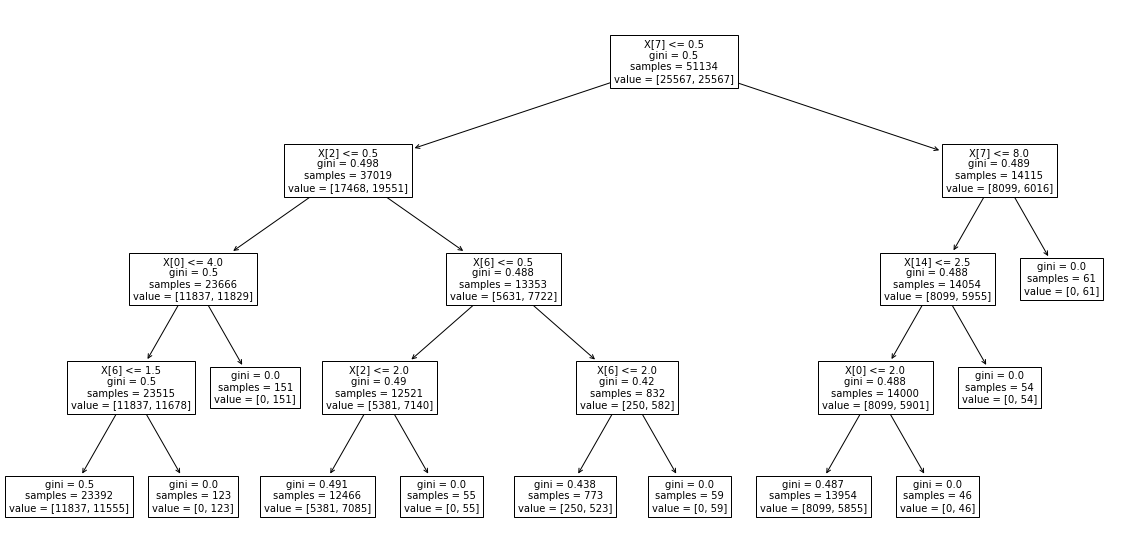

In [20]:
# Import Matplotlib to create the visualization and tree from sklearn
import matplotlib.pyplot as plt
from sklearn import tree

# Plot the decision tree to create the visualization
fig, ax = plt.subplots(figsize = (20, 10))
tree.plot_tree(dtc, fontsize = 10)

# Print the plot with plt.show().
plt.show()